https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [2]:
# Run in python console
import nltk; nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\shitiza\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

In [4]:
data_dir = './new_data/new_data/'

In [5]:
#!pip install pyLDAvis
#!pip install --upgrade gensim

In [6]:
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
### outdated
#import pyLDAvis.gensim  # don't skip this
import pyLDAvis.gensim_models as gensimvis
pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

C:\Users\shitiza\Anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


#### What does LDA do?
LDA’s approach to topic modeling is it considers each document as a collection of topics in a certain proportion. And each topic as a collection of keywords, again, in a certain proportion.

Once you provide the algorithm with the number of topics, all it does it to rearrange the topics distribution within the documents and keywords distribution within the topics to obtain a good composition of topic-keywords distribution.

When I say topic, what is it actually and how it is represented?

A topic is nothing but a collection of dominant keywords that are typical representatives. Just by looking at the keywords, you can identify what the topic is all about.

The following are key factors to obtaining good segregation topics:

The quality of text processing.
The variety of topics the text talks about.
The choice of topic modeling algorithm.
The number of topics fed to the algorithm.
The algorithms tuning parameters.

#### Prepare Stopwords

In [7]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
user_stop_wrds = list(set(['from', 'subject', 'reuse','open', 'edu','study','treatment','rate' ,'system', 'patients',
                   'effect','management','response','department','registry','market','effect','type','non',
                  'subject','power','approach','procedure','assesment','phase','post','body','compared','year','area','unit','treat',
                  'health','device','life','impact','base','safety','leave','control','leads','efficacy','follow','first','disease',
                  'human','global','feasibility','care','match','free','need','timing','site','event', 'index' ,'agreement','day','month',
                  'performance','follow','guide','outcome','clinical','evaluate','trial', 'evaluation','participant','test','informed', 'consent']))
stop_words.extend(user_stop_wrds)

####  Remove emails and newline characters

In [8]:
def pre_cleanup(df,colName) :
    # Convert to list
    data = df[~df[colName].isna()][colName].str.lower().values.tolist()

    # Remove Emails
    data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

    # Remove new line characters
    data = [re.sub('\s+', ' ', sent) for sent in data]

    # Remove distracting single quotes
    data = [re.sub("\'", "", sent) for sent in data]
    
    #for x in user_stop_wrds:
    #    data = [re.sub(x, "", sent.lower()) for sent in data]
    return data


#### Tokenize words and Clean-up text

In [9]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence).lower(), deacc=True))  # deacc=True removes punctuations


#### Creating Bigram and Trigram Models
Bigrams are two words frequently occurring together in the document. Trigrams are 3 words frequently occurring.

Some examples in our example are: ‘front_bumper’, ‘oil_leak’, ‘maryland_college_park’ etc.

Gensim’s Phrases model can build and implement the bigrams, trigrams, quadgrams and more. The two important arguments to Phrases are min_count and threshold. The higher the values of these param, the harder it is for words to be combined to bigrams.

In [24]:
def build_Qgrams(data_words) :
    # Build the bigram and trigram models
    bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
    trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

    # Faster way to get a sentence clubbed as a trigram/bigram
    bigram_mod = gensim.models.phrases.Phraser(bigram)
    trigram_mod = gensim.models.phrases.Phraser(trigram)

    # See trigram example
    #print(trigram_mod[bigram_mod[data_words[0]]])
    return(bigram_mod,trigram_mod)

#### Remove Stopwords, Make Bigrams and Lemmatize

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc).lower()) if word.lower() not in stop_words] for doc in texts]


def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
def lemmatize_fxn(data_words) : 
    # Remove Stop Words
    data_words_nostops = remove_stopwords(data_words)
    
    # Form Bigrams
    data_words_bigrams = make_bigrams(data_words_nostops)

    # Initialize spacy 'en' model, keeping only tagger component (for efficiency)
    # python3 -m spacy download en
    #nlp = spacy.load('en', disable=['parser', 'ner'])
    
    # Do lemmatization keeping only noun, adj, vb, adv
    data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ',  'ADV'])

    return data_lemmatized

#### Create the Dictionary and Corpus needed for Topic Modeling

In [15]:
def create_corpus(data_lemmatized) :
    # Create Dictionary
   
    id2word = corpora.Dictionary(data_lemmatized)

    # Create Corpus
    texts = data_lemmatized

    # Term Document Frequency
    corpus = [id2word.doc2bow(text) for text in texts]

    # View
    #print(corpus[:1])
    return (corpus,id2word)

#### Compute Model Perplexity and Coherence Score
- Model perplexity and topic coherence provide a convenient measure to judge how good a given topic model is. 
- In my experience, topic coherence score, in particular, has been more helpful.

In [16]:
def computeScores(lda_model) :
    # Compute Perplexity
    print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    coherence_lda = coherence_model_lda.get_coherence()
    print('\nCoherence Score: ', coherence_lda)

Gensim creates a unique id for each word in the document. The produced corpus shown above is a mapping of (word_id, word_frequency).

For example, (0, 1) above implies, word id 0 occurs once in the first document. Likewise, word id 1 occurs twice and so on.

This is used as the input by the LDA model.

If you want to see what word a given id corresponds to, pass the id as a key to the dictionary.

In [42]:
# 1. Wordcloud of Top N words in each topic
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
from collections import Counter

def topic_wordCloud(lda_model,xn,yn) :
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

    cloud = WordCloud(stopwords=stop_words,
                      background_color='white',
                      width=2500,
                      height=1800,
                      max_words=10,
                      colormap='tab10',
                      color_func=lambda *args, **kwargs: cols[i],
                      prefer_horizontal=1.0)

    topics = lda_model.show_topics(formatted=False)

    fig, axes = plt.subplots(xn, yn, figsize=(12,12), sharex=True, sharey=True)

    for i, ax in enumerate(axes.flatten()):
        fig.add_subplot(ax)
        topic_words = dict(topics[i][1])
        cloud.generate_from_frequencies(topic_words, max_font_size=300)
        plt.gca().imshow(cloud)
        plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
        plt.gca().axis('off')


def topic_word_freqBarPlot(lda_model,xn,yn) :

    topics = lda_model.show_topics(formatted=False)
    data_flat = [w for w_list in data_words for w in w_list]
    counter = Counter(data_flat)

    out = []
    for i, topic in topics:
        for word, weight in topic:
            out.append([word, i , weight, counter[word]])

    df = pd.DataFrame(out, columns=['word', 'topic_id', 'importance', 'word_count'])        

    # Plot Word Count and Weights of Topic Keywords
    fig, axes = plt.subplots(xn,yn , figsize=(16,10), sharey=True, dpi=160)
    cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
    for i, ax in enumerate(axes.flatten()):
        ax.bar(x='word', height="word_count", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.5, alpha=0.3, label='Word Count')
        ax_twin = ax.twinx()
        ax_twin.bar(x='word', height="importance", data=df.loc[df.topic_id==i, :], color=cols[i], width=0.2, label='Weights')
        ax.set_ylabel('Word Count', color=cols[i])
        ax_twin.set_ylim(0, 0.020); ax.set_ylim(0, 5000)
        ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
        ax.tick_params(axis='y', left=False)
        ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
        ax.legend(loc='upper left'); ax_twin.legend(loc='upper right')

    fig.tight_layout(w_pad=2)    

#### Import Clinical-Trial Data


In [139]:
clnT_csv = data_dir + '/ClinicalTrialsGov-Pacemaker-wContent.csv'
clnT_df = pd.read_csv(clnT_csv)

In [140]:
clnT_df.head(2)

,Unnamed: 0,Rank,NCT Number,Title,Acronym,Status,Study Results,Conditions,Interventions,Outcome Measures,...,Completion Date,First Posted,Results First Posted,Last Update Posted,Locations,Study Documents,URL,Detailed Description,Study Arms,Eligibility Criteria
0,0,1,NCT04926792,Taiwan Registry for Leadless Pacemaker,NaN,Not yet recruiting,No Results Available,Performance of the Leadless Pacemaker in Taiwan Population,Device: Leadless Pacemaker,Acute complication|Subacute complication|Leadless Pacemaker performance|Successful implant,...,June 2025,"June 15, 2021",NaN,"June 15, 2021",NaN,NaN,https://ClinicalTrials.gov/show/NCT04926792,The purpose of this registry is to investigate the safety and efficiency performance of the\r\n ...,NaN,Inclusion Criteria:\r\n\r\n 1. The patients who had successfully received leadless pace...
1,1,2,NCT02931760,Placement Of Cardiac PacemaKer Trial (POCKET)-RCT,POCKET-RCT,Unknown status,No Results Available,Pacemaker Ddd,Device: subcutaneous pacemaker|Device: intramuscular pacemaker,patient overall satisfaction|complications due to pacemaker procedure|pain problems due to pacem...,...,June 2019,"October 13, 2016",NaN,"October 13, 2016","Region Gavleborg, Gävle, Sweden",NaN,https://ClinicalTrials.gov/show/NCT02931760,Background: Implantation of a cardiac pacemaker may be indicated in patients with a\r\n sig...,"['subcutaneous pacemaker', 'intramuscular pacemaker']","Inclusion Criteria:\r\n\r\n - Indication of a bradycardia pacemaker (DDDR, VVIR).\r\n\..."


### ClinicalTrials Topic Extraction using TITLE column

In [141]:
data_words = list(sent_to_words(pre_cleanup(clnT_df,'Title')))
#print(data_words[:1])
bigram_mod,trigram_mod = build_Qgrams(data_words)
nlp = spacy.load("en_core_web_sm")
data_lemmatized = lemmatize_fxn(data_words)
corpus,id2word = create_corpus(data_lemmatized)

In [142]:

def format_topics_sentences(ldamodel=None, corpus=corpus, texts=data_words):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

####  Building the Topic Model


In [143]:

# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Build LDA model
num_of_topics=4

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### View the topics in LDA model

In [144]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

In [145]:
computeScores(lda_model)


Perplexity:  -7.084186058507287

Coherence Score:  0.5727314605581629


#### Visualize the topics-keywords


In [146]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\shitiza\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.282687 -0.053120       1        1  35.107970
2     -0.044076  0.163771       2        1  23.649544
1     -0.149106 -0.206889       3        1  22.400038
0     -0.089505  0.096238       4        1  18.842448, topic_info=              Term        Freq       Total Category  logprob  loglift
32           valve  190.000000  190.000000  Default  30.0000  30.0000
40           heart  104.000000  104.000000  Default  29.0000  29.0000
85          atrial  102.000000  102.000000  Default  28.0000  28.0000
88    fibrillation   85.000000   85.000000  Default  27.0000  27.0000
388         aortic   99.000000   99.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
179         injury    4.384405    4.987362   Topic4  -5.4927   1.5402
811          death    4.397253    5.007420   Topic4  -5.4897   1.5391
1197    neuropathy    7.154379    8.218361   Topic4  -5.0030   1.5304
1314    infarction    4.833216    6.956696   Topic4  -5.3952   1.3049
1          cardiac    5.411672   92.381794   Topic4  -5.2821  -1.1683

[166 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
23        3  0.988332     ablation
1228      1  0.714749      acurate
1228      2  0.274904      acurate
605       3  0.763698        acute
605       4  0.229110        acute
...     ...       ...          ...
32        1  0.997363        valve
33        1  0.978574  ventricular
1366      3  0.937555      vitamin
1561      2  0.901683         wild
401       2  0.950748         year

[148 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 3, 2, 1])

In [147]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.5628,"therapy, surgical, cardiac, tavi, child, intervention, pacemaker, early, pilot, mri","[taiwan, registry, for, leadless, pacemaker]"
1,1,2.0,0.8482,"therapy, surgical, cardiac, tavi, child, intervention, pacemaker, early, pilot, mri","[placement, of, cardiac, pacemaker, trial, pocket, rct]"
2,2,3.0,0.6245,"valve, aortic, replacement, transcatheter, pacing, implantation, stenosis, cardiac, ventricular,...","[cost, utility, analysis, of, ambulatory, care, compared, to, conventional, patient, care, of, p..."
3,3,2.0,0.8498,"therapy, surgical, cardiac, tavi, child, intervention, pacemaker, early, pilot, mri","[morbidity, mortality, and, gender, differences, in, patients, with, pacemakers]"
4,4,2.0,0.7083,"therapy, surgical, cardiac, tavi, child, intervention, pacemaker, early, pilot, mri","[evaluation, of, pacemakers, in, children]"


In [148]:
# Display setting to show more characters in column
pd.options.display.max_colwidth = 100
def kryContri_perTopic(df_topic_sents_keywords) :
    sent_topics_sorteddf_mallet = pd.DataFrame()
    sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

    for i, grp in sent_topics_outdf_grpd:
        sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                                 grp.sort_values(['Perc_Contribution'], ascending=False).head(1)], 
                                                axis=0)

    # Reset Index    
    sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

    # Format
    sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Representative Text"]

    # Show
    return sent_topics_sorteddf_mallet
    

In [149]:
sent_topics_sorteddf_mallet = kryContri_perTopic(df_topic_sents_keywords)
sent_topics_sorteddf_mallet.head(num_of_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.8907,"heart, failure, surgery, stimulation, chronic, standard, invasive, effect, lead, cold","[cerebral, responses, during, bilateral, unilateral, sacral, nerve, stimulation, for, idiopathic..."
1,1.0,0.9185,"atrial, fibrillation, ablation, cardiovascular, remote, high, arrhythmia, syndrome, cancer, myoc...","[rhythm, control, catheter, ablation, with, or, without, anti, arrhythmic, drug, control, of, ma..."
2,2.0,0.9156,"therapy, surgical, cardiac, tavi, child, intervention, pacemaker, early, pilot, mri","[sleep, apnea, diagnosis, using, novel, pacemaker, algorithm, and, link, with, aldosterone, plas..."
3,3.0,0.9375,"valve, aortic, replacement, transcatheter, pacing, implantation, stenosis, cardiac, ventricular,...","[comparison, of, cardiac, function, between, left, bundle, branch, pacing, and, right, ventricul..."


In [154]:
df_dominant_topic.merge(clnT_df[~clnT_df['Title'].isna()], left_index=True,right_index=True).rename(columns={'Document_No':'id'}).drop(['Text','Unnamed: 0'],axis=1).to_csv('clinicTrial_LDA_cat_output.csv',index=False)

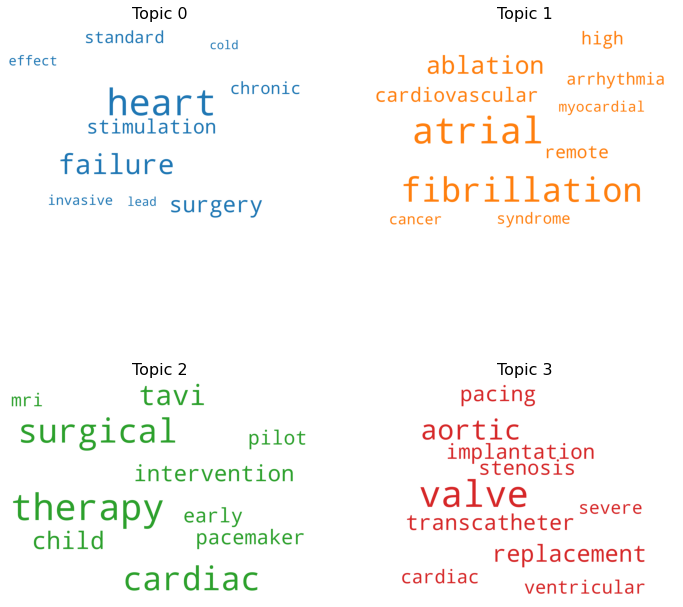

In [151]:
topic_wordCloud(lda_model,int(num_of_topics/2),2)

<ipython-input-42-f505a2ae843b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


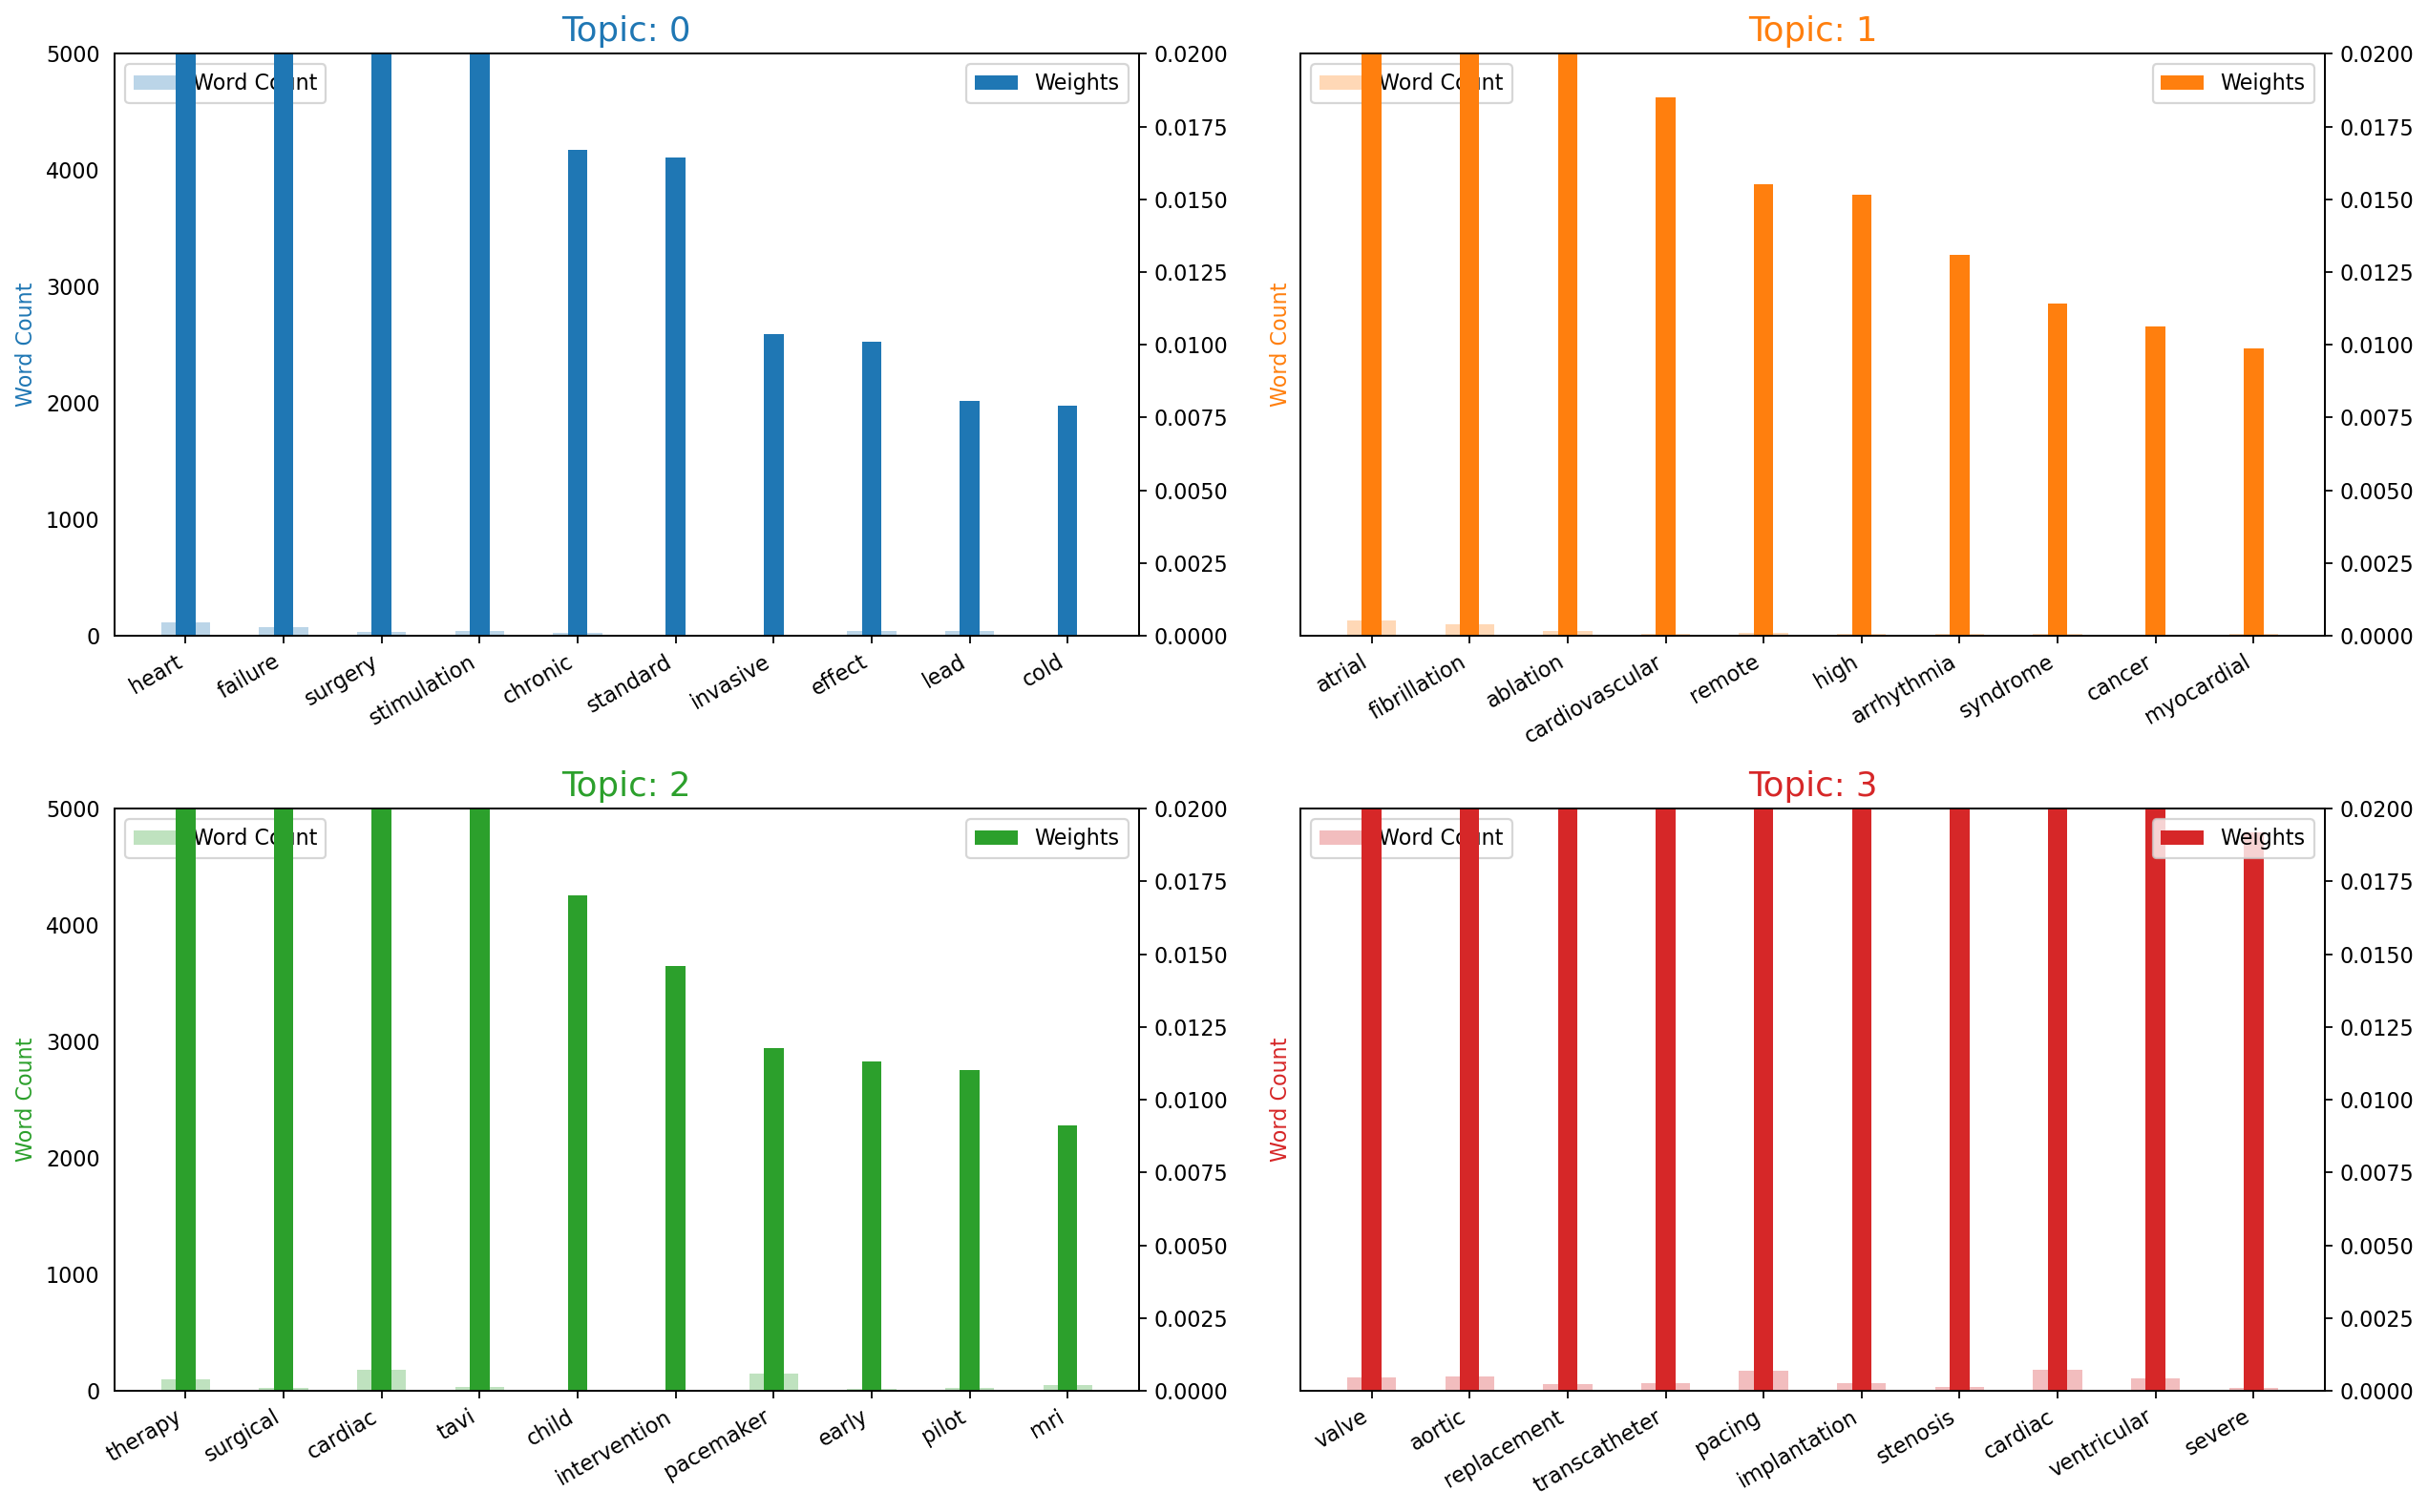

In [152]:
topic_word_freqBarPlot(lda_model,int(num_of_topics/2),2)

### ClinicalTrials Topic Extraction using Detailed Description column

In [45]:
data_words = list(sent_to_words(pre_cleanup(clnT_df,'Detailed Description')))
#print(data_words[:1])
data_lemmatized = lemmatize_fxn(data_words)

####  Building the Topic Model


In [46]:
corpus,id2word = create_corpus(data_lemmatized)
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Build LDA model
num_of_topics=4

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### View the topics in LDA model

In [47]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

In [48]:
computeScores(lda_model)


Perplexity:  -7.641999015324522

Coherence Score:  0.43185455221026914


#### Visualize the topics-keywords


In [49]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\shitiza\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.131195 -0.107014       1        1  52.987982
3     -0.126527 -0.140137       2        1  32.900566
2     -0.118576  0.252131       3        1  12.049201
0      0.376299 -0.004980       4        1   2.062251, topic_info=              Term        Freq       Total Category  logprob  loglift
782        symptom  235.000000  235.000000  Default  30.0000  30.0000
504          valve  535.000000  535.000000  Default  29.0000  29.0000
227         tissue  135.000000  135.000000  Default  28.0000  28.0000
805          blood  256.000000  256.000000  Default  27.0000  27.0000
1534      ischemic  110.000000  110.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
805          blood   19.667218  256.164674   Topic4  -4.6272   1.3145
108   inflammatory   10.680914   36.096799   Topic4  -5.2377   2.6636
643       cerebral   10.097002   17.499808   Topic4  -5.2939   3.3314
2173     treatment   10.341522   38.944907   Topic4  -5.2700   2.5554
854       survival   10.327227   66.946261   Topic4  -5.2714   2.0123

[288 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
389       1  0.793090   ablation
389       2  0.206079   ablation
13        1  0.155361     access
13        2  0.845853     access
2851      3  0.976411       acid
...     ...       ...        ...
387       4  0.044386       well
2900      2  0.376888  worldwide
2900      4  0.596740  worldwide
252       1  0.761446       year
252       2  0.236311       year

[444 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 3, 1])

In [50]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,1.0,0.9856,"heart, patient, group, datum, month, pacemaker, cardiac, ventricular, therapy, analysis","[the, purpose, of, this, registry, is, to, investigate, the, safety, and, efficiency, performanc..."
1,1,1.0,0.7050,"heart, patient, group, datum, month, pacemaker, cardiac, ventricular, therapy, analysis","[background, implantation, of, cardiac, pacemaker, may, be, indicated, in, patients, with, signi..."
2,2,1.0,0.5431,"heart, patient, group, datum, month, pacemaker, cardiac, ventricular, therapy, analysis","[in, france, nearly, permanent, pacemakers, are, implanted, each, year, the, pacemaker, longevit..."
3,3,1.0,0.5021,"heart, patient, group, datum, month, pacemaker, cardiac, ventricular, therapy, analysis","[although, advances, in, device, and, lead, technology, have, expanded, the, ability, to, implan..."
4,4,1.0,0.9967,"heart, patient, group, datum, month, pacemaker, cardiac, ventricular, therapy, analysis","[this, is, multicenter, prospective, open, interventional, study, all, patients, will, undergo, ..."


In [51]:
sent_topics_sorteddf_mallet = kryContri_perTopic(df_topic_sents_keywords)
sent_topics_sorteddf_mallet.head(num_of_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9987,"ischemic, tissue, reperfusion, infarct, remote, conditioning, injury, brain, symptom, ischemia","[stroke, is, the, second, leading, cause, of, death, worldwide, and, leading, cause, of, serious..."
1,1.0,0.9995,"heart, patient, group, datum, month, pacemaker, cardiac, ventricular, therapy, analysis","[purpose, the, purpose, of, this, clinical, investigation, is, to, assess, whether, cardiac, the..."
2,2.0,0.8524,"blood, surgery, pressure, exercise, cell, muscle, level, heart, participant, value","[investigate, the, effect, of, external, diaphragmatic, pacemaker, on, chronic, cor, pulmonale, ..."
3,3.0,0.9992,"valve, risk, aortic, surgery, surgical, cardiac, high, tavi, implantation, severe","[permanent, pacemaker, implantation, is, widely, recognized, clinical, event, associated, with, ..."


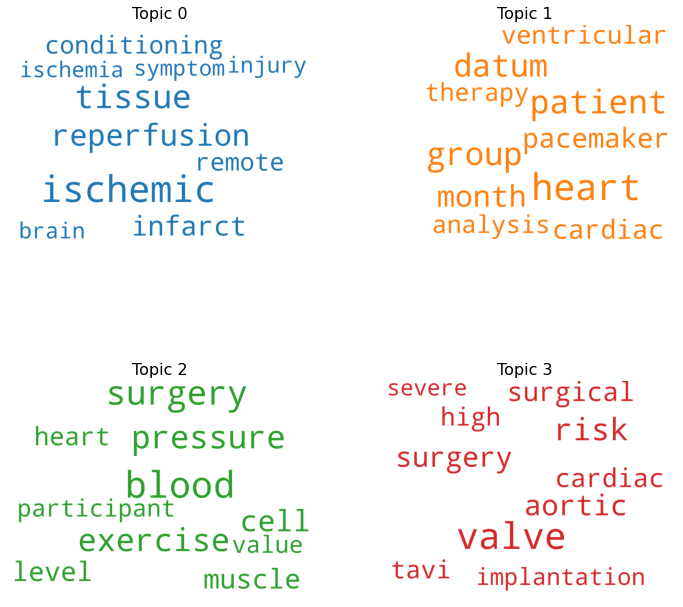

In [52]:
topic_wordCloud(lda_model,int(num_of_topics/2),2)

<ipython-input-42-f505a2ae843b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


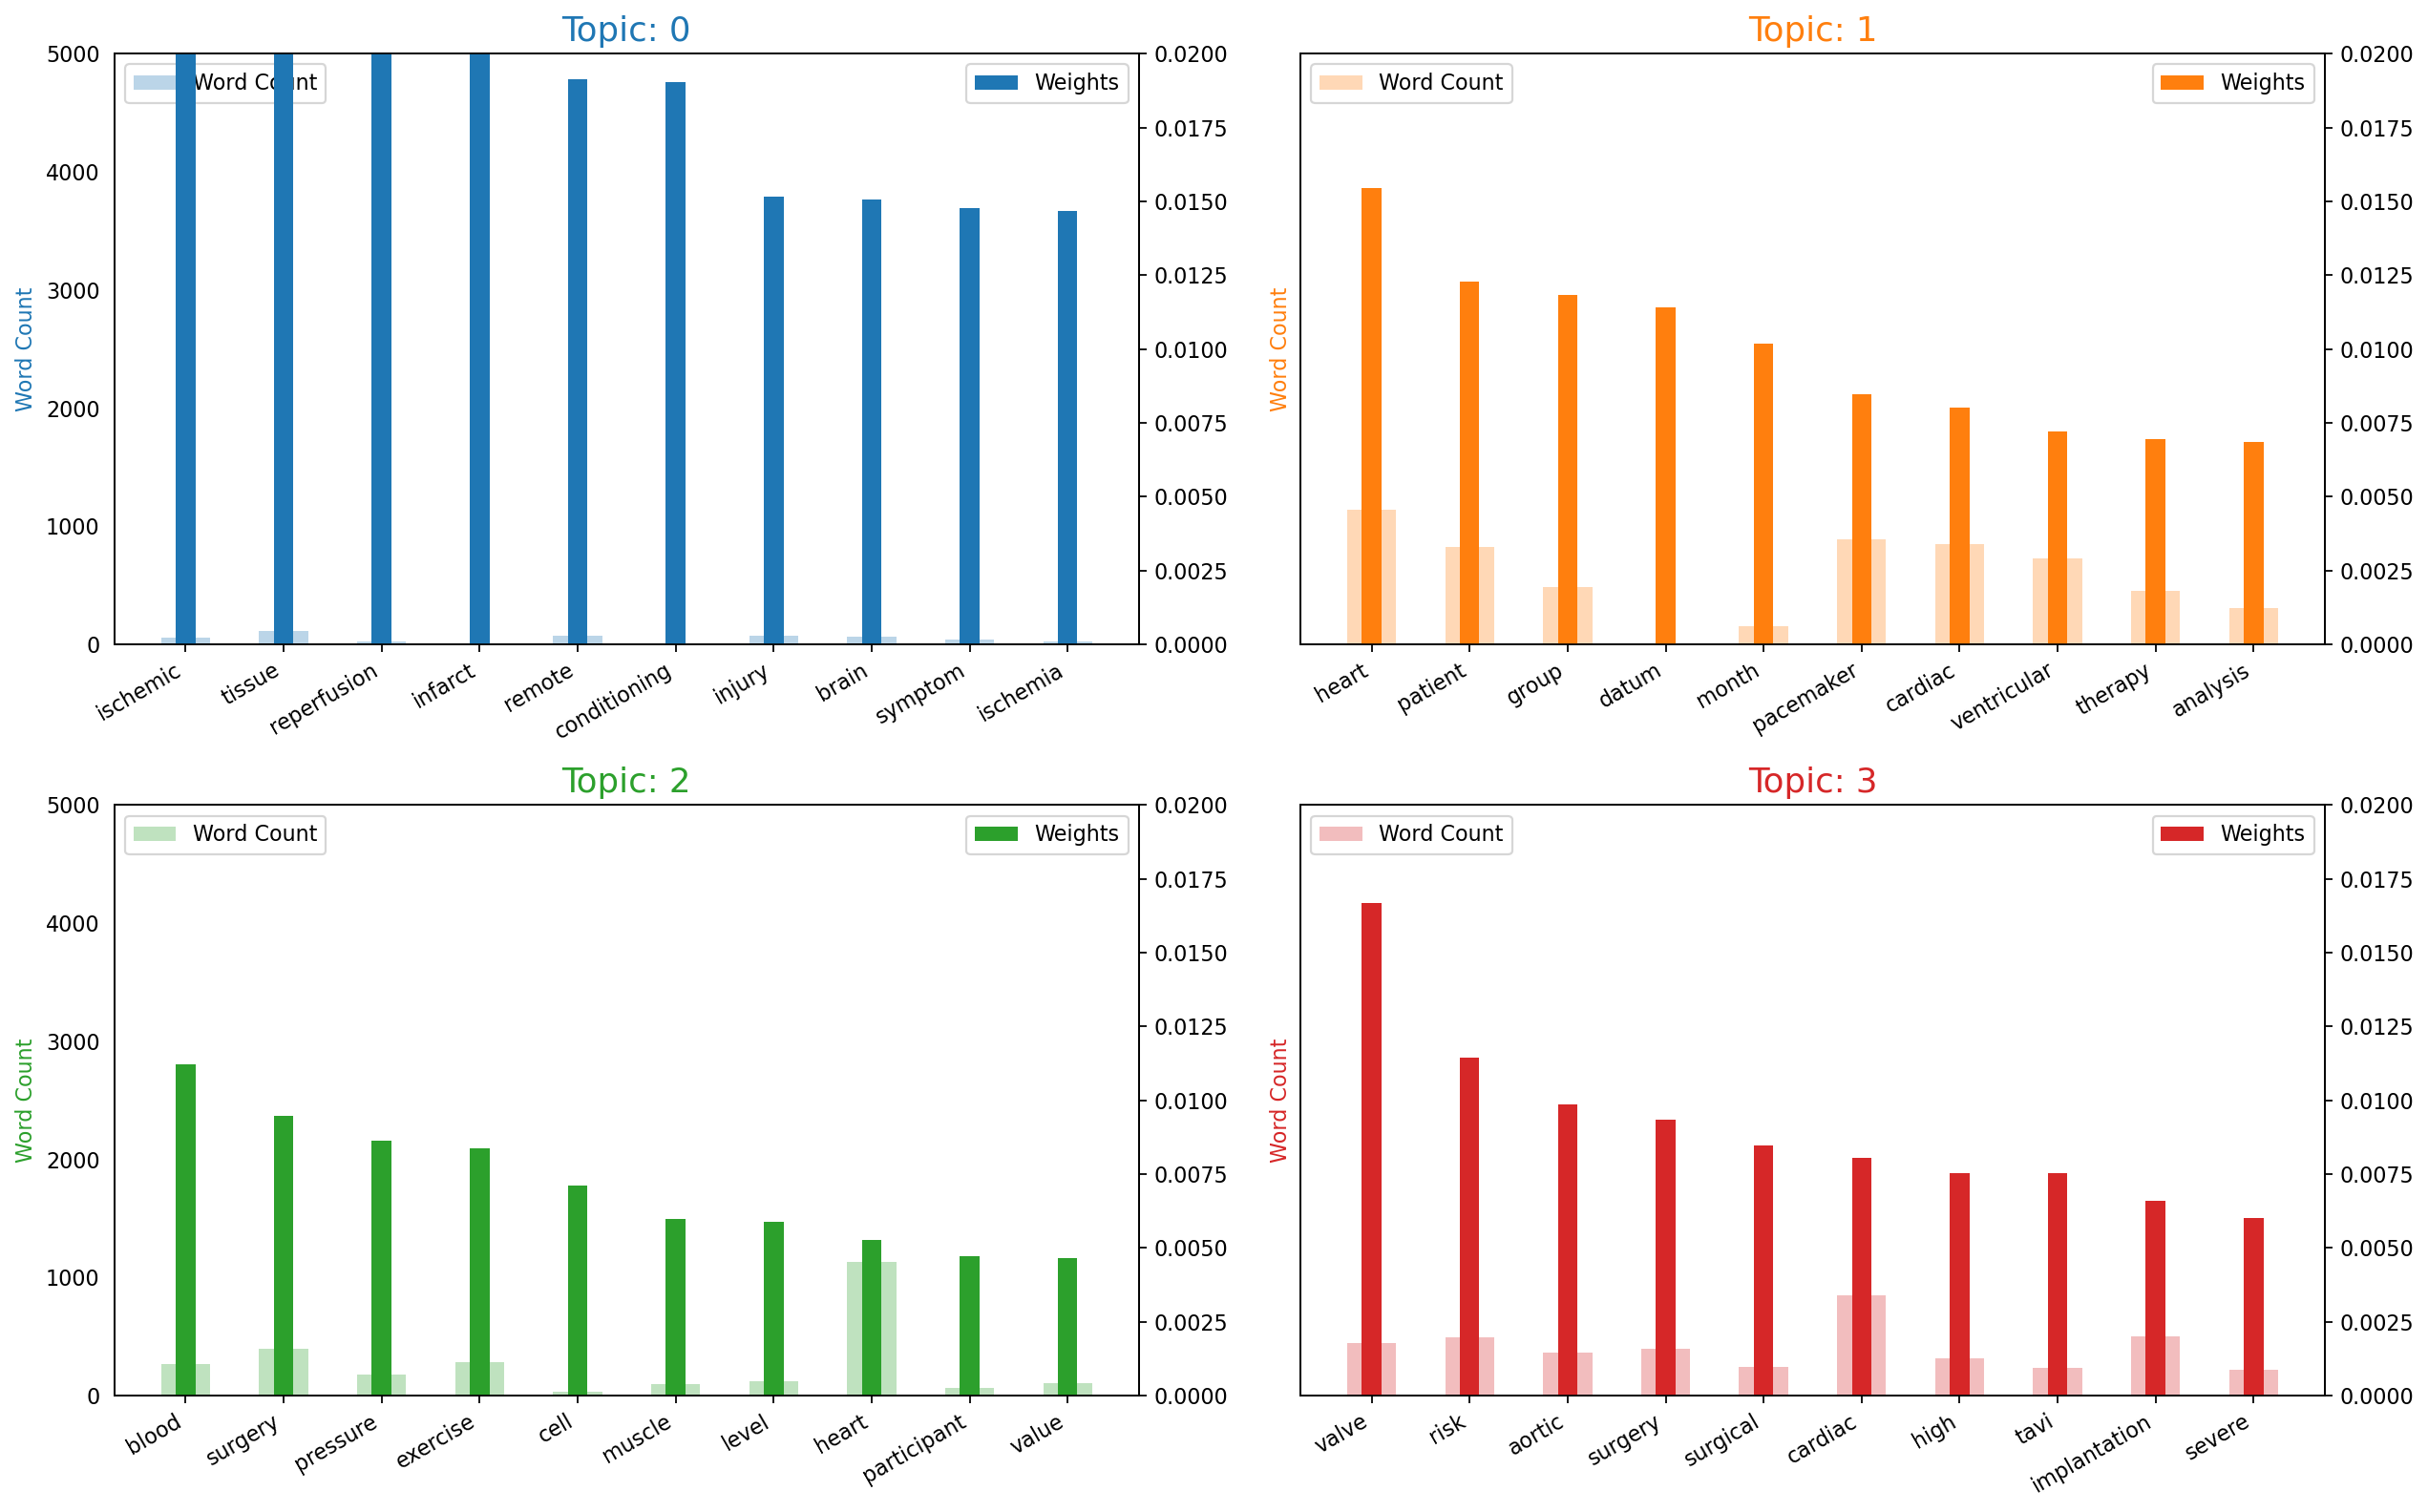

In [53]:
topic_word_freqBarPlot(lda_model,int(num_of_topics/2),2)

### ClinicalTrials Topic Extraction using Eligibility Criteria column

In [54]:
data_words = list(sent_to_words(pre_cleanup(clnT_df,'Eligibility Criteria')))
#print(data_words[:1])
data_lemmatized = lemmatize_fxn(data_words)

####  Building the Topic Model


In [55]:
corpus,id2word = create_corpus(data_lemmatized)
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Build LDA model
num_of_topics=4

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### View the topics in LDA model

In [56]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

In [57]:
computeScores(lda_model)


Perplexity:  -6.787086659438081

Coherence Score:  0.3823704329208301


#### Visualize the topics-keywords


In [58]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\shitiza\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.136033  0.216439       1        1  35.612580
3     -0.092660 -0.203917       2        1  28.255749
1     -0.054538 -0.041729       3        1  25.766047
2      0.283230  0.029207       4        1  10.365625, topic_info=          Term         Freq        Total Category  logprob  loglift
1    criterion  2196.000000  2196.000000  Default  30.0000  30.0000
201      valve   768.000000   768.000000  Default  29.0000  29.0000
431     aortic   629.000000   629.000000  Default  28.0000  28.0000
4    inclusion  1249.000000  1249.000000  Default  27.0000  27.0000
2    exclusion  1148.000000  1148.000000  Default  26.0000  26.0000
..         ...          ...          ...      ...      ...      ...
262       risk    35.384652   258.515936   Topic4  -5.3730   0.2780
269       week    31.643508   161.964077   Topic4  -5.4848   0.6338
243  condition    32.669724   295.274772   Topic4  -5.4529   0.0652
191  pregnancy    31.186970   236.398346   Topic4  -5.4993   0.2412
491   previous    31.253138   307.269948   Topic4  -5.4972  -0.0189

[277 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
235       1  0.838572   ability
235       2  0.031946   ability
235       4  0.119796   ability
428       1  0.006829  ablation
428       3  0.990240  ablation
...     ...       ...       ...
59        3  0.201558     woman
90        1  0.757348      year
90        2  0.061212      year
90        3  0.152430      year
90        4  0.028806      year

[400 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 4, 2, 3])

In [59]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.9296,"criterion, inclusion, exclusion, patient, year, pacemaker, age, implant, subject, able","[inclusion, criteria, the, patients, who, had, successfully, received, leadless, pacemaker, impl..."
1,1,0.0,0.7973,"criterion, inclusion, exclusion, patient, year, pacemaker, age, implant, subject, able","[inclusion, criteria, indication, of, bradycardia, pacemaker, dddr, vvir, exclusion, criteria, c..."
2,2,0.0,0.7913,"criterion, inclusion, exclusion, patient, year, pacemaker, age, implant, subject, able","[inclusion, criteria, man, or, woman, over, years, old, replacement, of, permanent, pacemakers, ..."
3,3,0.0,0.9620,"criterion, inclusion, exclusion, patient, year, pacemaker, age, implant, subject, able","[inclusion, criteria, all, patients, registered, in, the, pacemaker, database, of, the, departme..."
4,4,0.0,0.5400,"criterion, inclusion, exclusion, patient, year, pacemaker, age, implant, subject, able","[inclusion, criteria, pediatric, age, group, month, years, indicated, for, permanent, cardiac, p..."


In [60]:
sent_topics_sorteddf_mallet = kryContri_perTopic(df_topic_sents_keywords)
sent_topics_sorteddf_mallet.head(num_of_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9904,"criterion, inclusion, exclusion, patient, year, pacemaker, age, implant, subject, able","[inclusion, criteria, the, following, initial, inclusion, criteria, must, be, met, for, subject,..."
1,1.0,0.9149,"heart, atrial, failure, month, fibrillation, prior, ventricular, cardiac, history, previous","[inclusion, criteria, the, patient, with, persistent, or, permanent, atrial, fibrillation, hr, e..."
2,2.0,0.8566,"investigator, disorder, active, history, prior, score, presence, medication, cancer, least","[inclusion, criteria, an, average, defecation, frequency, df, of, per, week, based, on, week, de..."
3,3.0,0.9952,"valve, aortic, severe, stenosis, heart, cardiac, day, risk, mitral, patient","[inclusion, criteria, high, risk, subject, must, have, co, morbidities, such, that, one, cardiol..."


In [78]:
df_dominant_topic.shape,clnT_df.columns,  clnT_df[~clnT_df['Eligibility Criteria'].isna()].shape

((8030, 5),
 Index(['PMID', 'Title', 'Authors', 'Citation', 'First Author', 'Journal/Book',
        'Publication Year', 'Create Date', 'PMCID', 'NIHMS ID', 'DOI',
        'Abstract'],
       dtype='object'))

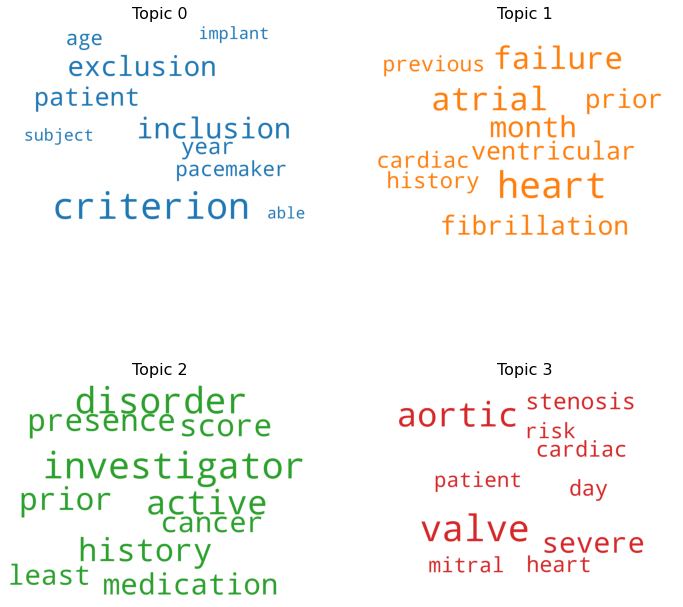

In [61]:
topic_wordCloud(lda_model,int(num_of_topics/2),2)

<ipython-input-42-f505a2ae843b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


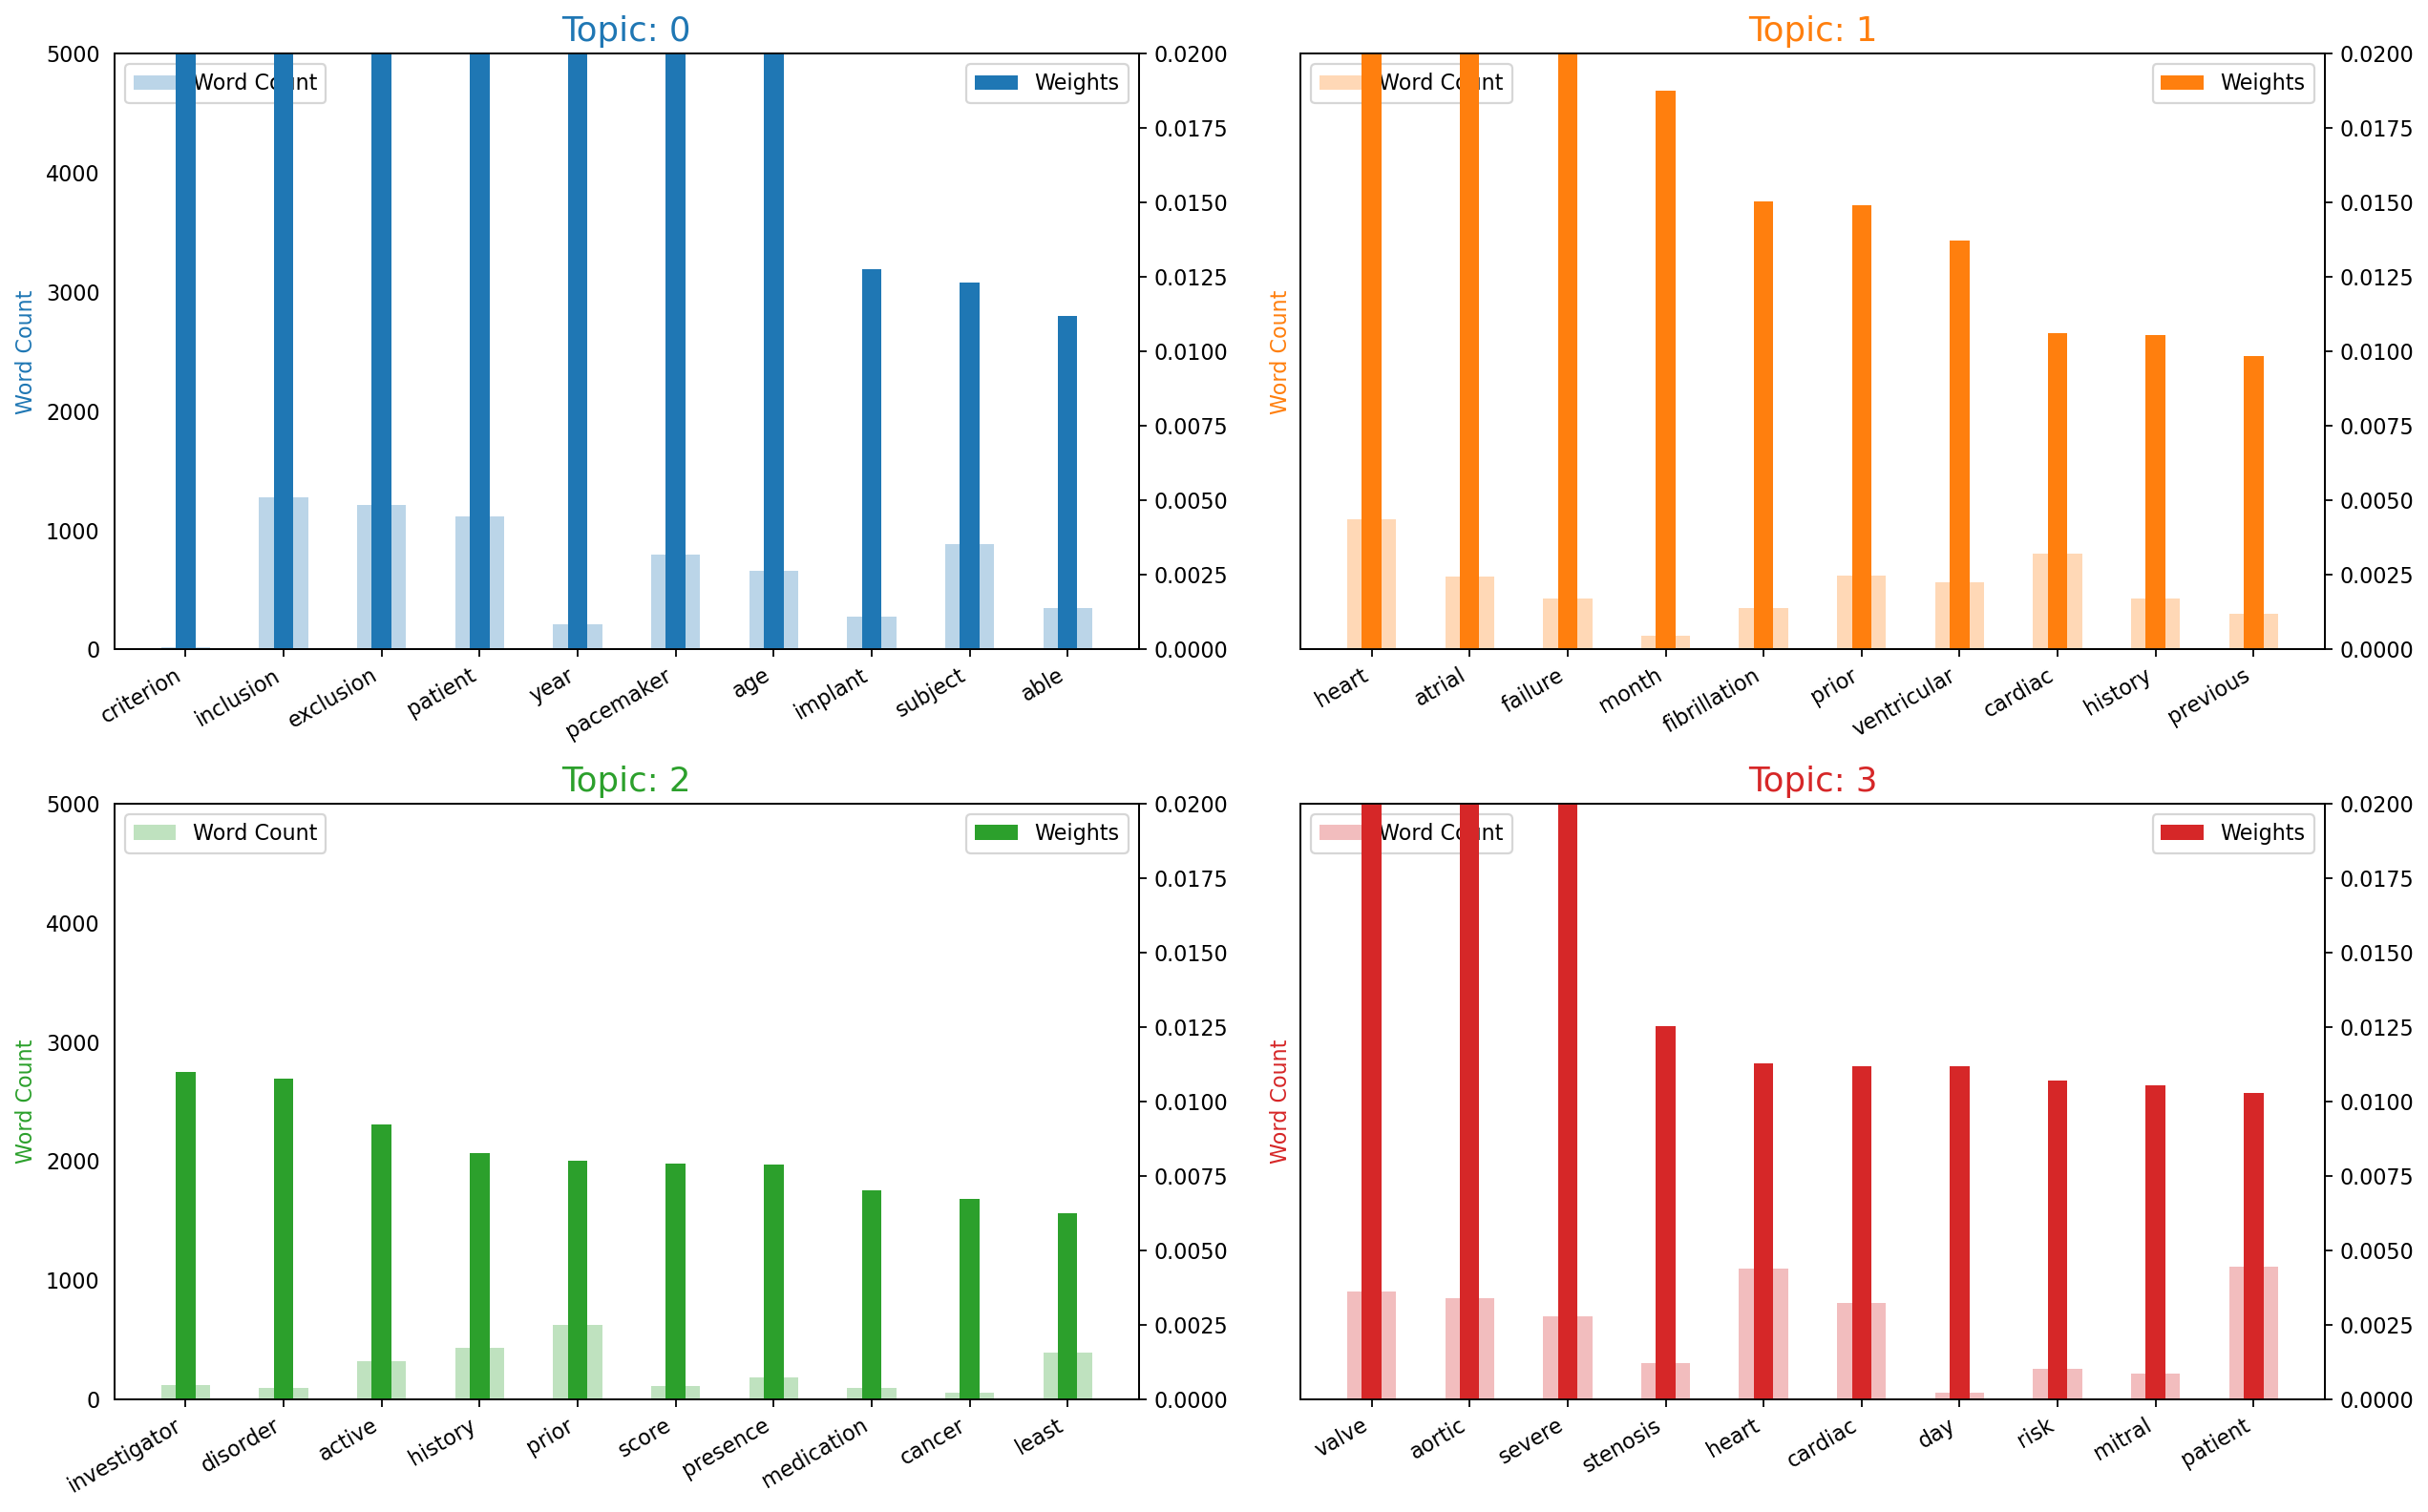

In [62]:
topic_word_freqBarPlot(lda_model,int(num_of_topics/2),2)

## Import PubMed Data


In [127]:
clnT_csv = data_dir + '/PubMed_wAbstracts-Pacemaker.csv'
clnT_df = pd.read_csv(clnT_csv)

In [128]:
clnT_df.head(2)

,PMID,Title,Authors,Citation,First Author,Journal/Book,Publication Year,Create Date,PMCID,NIHMS ID,DOI,Abstract
0,31070324,[Micra® leadless pacemaker],"Lancellotti P, Gach O, Marechal P, Robinet S.",Rev Med Liege. 2019 Sup;74(S1):S104-S108.,Lancellotti P,Rev Med Liege,2019,2019/05/10,NaN,NaN,NaN,The Micra® leadless pacemaker has demonstrated both safety and efficacy in the short and mid-ter...
1,31373521,Pacemaker complications and costs: a nationwide economic study,"Clémenty N, Fernandes J, Carion PL, de Léotoing L, Lamarsalle L, Wilquin-Bequet F, Wolff C, Verh...",J Med Econ. 2019 Nov;22(11):1171-1178. doi: 10.1080/13696998.2019.1652186. Epub 2019 Aug 30.,Clémenty N,J Med Econ,2019,2019/08/03,NaN,NaN,10.1080/13696998.2019.1652186,Aims: Novel leadless pacemakers (LPMs) may reduce complications and associated costs related to ...


### PubMed Topic Extraction using Abstract column

In [129]:
data_words = list(sent_to_words(pre_cleanup(clnT_df,'Abstract')))
#print(data_words[:1])
data_lemmatized = lemmatize_fxn(data_words)

####  Building the Topic Model


In [130]:
corpus,id2word = create_corpus(data_lemmatized)
# Human readable format of corpus (term-frequency)
#[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]
# Build LDA model
num_of_topics=4

lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_of_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

#### View the topics in LDA model

In [131]:
# Print the Keyword in the 10 topics
#pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

How to interpret this?

Topic 0 is a represented as _0.016“car” + 0.014“power” + 0.010“light” + 0.009“drive” + 0.007“mount” + 0.007“controller” + 0.007“cool” + 0.007“engine” + 0.007“back” + ‘0.006“turn”.

It means the top 10 keywords that contribute to this topic are: ‘car’, ‘power’, ‘light’.. and so on and the weight of ‘car’ on topic 0 is 0.016.

The weights reflect how important a keyword is to that topic.

Looking at these keywords, can you guess what this topic could be? You may summarise it either are ‘cars’ or ‘automobiles’.

Likewise, can you go through the remaining topic keywords and judge what the topic is?

In [132]:
computeScores(lda_model)


Perplexity:  -7.465248281302046

Coherence Score:  0.6273084341301259


#### Visualize the topics-keywords


In [133]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

C:\Users\shitiza\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.047662  0.257698       1        1  29.862632
1     -0.194366 -0.112197       2        1  28.006331
3     -0.072394 -0.093647       3        1  21.774025
0      0.314423 -0.051855       4        1  20.357011, topic_info=            Term         Freq        Total Category  logprob  loglift
201        valve  6216.000000  6216.000000  Default  30.0000  30.0000
182    mortality  4008.000000  4008.000000  Default  29.0000  29.0000
832         tavr  3512.000000  3512.000000  Default  28.0000  28.0000
2         atrial  4513.000000  4513.000000  Default  27.0000  27.0000
108  ventricular  3873.000000  3873.000000  Default  26.0000  26.0000
..           ...          ...          ...      ...      ...      ...
157         also   513.490858  1195.414049   Topic4  -5.5731   0.7467
79         heart   608.525617  5392.691597   Topic4  -5.4032  -0.5900
56        result   575.650373  3887.489617   Topic4  -5.4588  -0.3183
135         time   530.297642  2643.008495   Topic4  -5.5408  -0.0145
114       change   475.536851   948.562553   Topic4  -5.6498   0.9012

[266 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
1967      1  0.999597     ablation
640       1  0.999463  abnormality
328       3  0.995580     accuracy
1151      4  0.997075   activation
453       4  0.999237     activity
...     ...       ...          ...
140       3  0.996768        visit
1180      4  0.998200      voltage
61        1  0.319601         year
61        2  0.460923         year
61        3  0.219451         year

[374 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 2, 4, 1])

In [134]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data_words)
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(5)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,3.0,0.4103,"cardiac, therapy, method, risk, datum, year, crt, high, conclusion, device","[the, micra, leadless, pacemaker, has, demonstrated, both, safety, and, efficacy, in, the, short..."
1,1,3.0,0.9537,"cardiac, therapy, method, risk, datum, year, crt, high, conclusion, device","[aims, novel, leadless, pacemakers, lpms, may, reduce, complications, and, associated, costs, re..."
2,2,2.0,0.7266,"atrial, heart, ventricular, cardiac, case, pacemaker, fibrillation, ablation, block, year","[runaway, pacemaker, is, phenomenon, in, which, pacemaker, induces, ventricular, tachycardia, as..."
3,3,3.0,0.7739,"cardiac, therapy, method, risk, datum, year, crt, high, conclusion, device","[background, most, outpatient, follow, ups, after, pacemaker, implantation, do, not, involve, ch..."
4,4,3.0,0.7846,"cardiac, therapy, method, risk, datum, year, crt, high, conclusion, device","[objective, the, incidence, of, cardiac, implantable, electronic, device, cied, infection, is, u..."


In [135]:
sent_topics_sorteddf_mallet = kryContri_perTopic(df_topic_sents_keywords)
sent_topics_sorteddf_mallet.head(num_of_topics)

,Topic_Num,Topic_Perc_Contrib,Keywords,Representative Text
0,0.0,0.9950,"circadian, cell, activity, scn, pacemaker, gene, expression, mouse, rhythm, clock","[the, circadian, clock, organizes, the, physiology, and, behavior, of, organisms, to, their, dai..."
1,1.0,0.9957,"valve, mortality, tavr, group, aortic, risk, high, implantation, year, outcome","[objective, this, multi, institutional, study, compares, the, long, term, outcome, of, elderly, ..."
2,2.0,0.9917,"atrial, heart, ventricular, cardiac, case, pacemaker, fibrillation, ablation, block, year","[complete, heart, block, chb, is, an, unfortunate, complication, of, an, anterior, and, inferior..."
3,3.0,0.9933,"cardiac, therapy, method, risk, datum, year, crt, high, conclusion, device","[background, patients, with, implantable, devices, such, as, pacemakers, pms, and, implantable, ..."


In [136]:
df_dominant_topic.merge(clnT_df[~clnT_df['Abstract'].isna()], left_index=True,right_index=True).rename(columns={'Document_No':'id'}).drop(['Text'],axis=1).to_csv('pubMed_LDA_cat_output.csv',index=False)


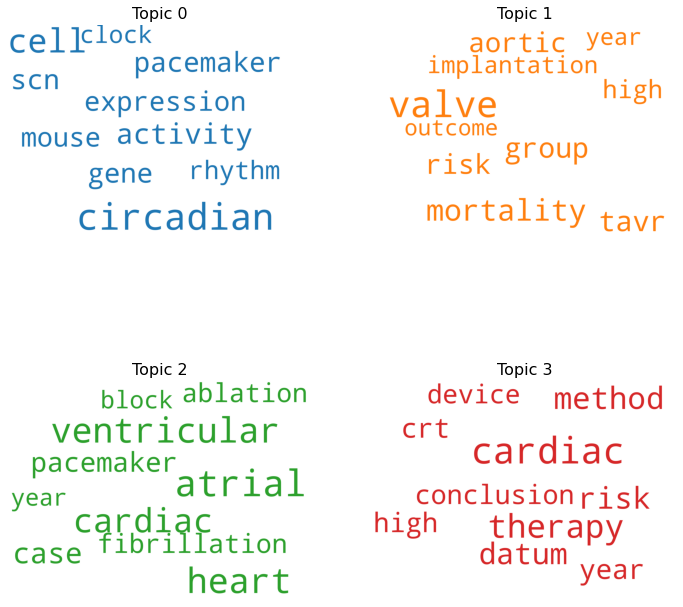

In [137]:
topic_wordCloud(lda_model,int(num_of_topics/2),2)

<ipython-input-42-f505a2ae843b>:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(df.loc[df.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')


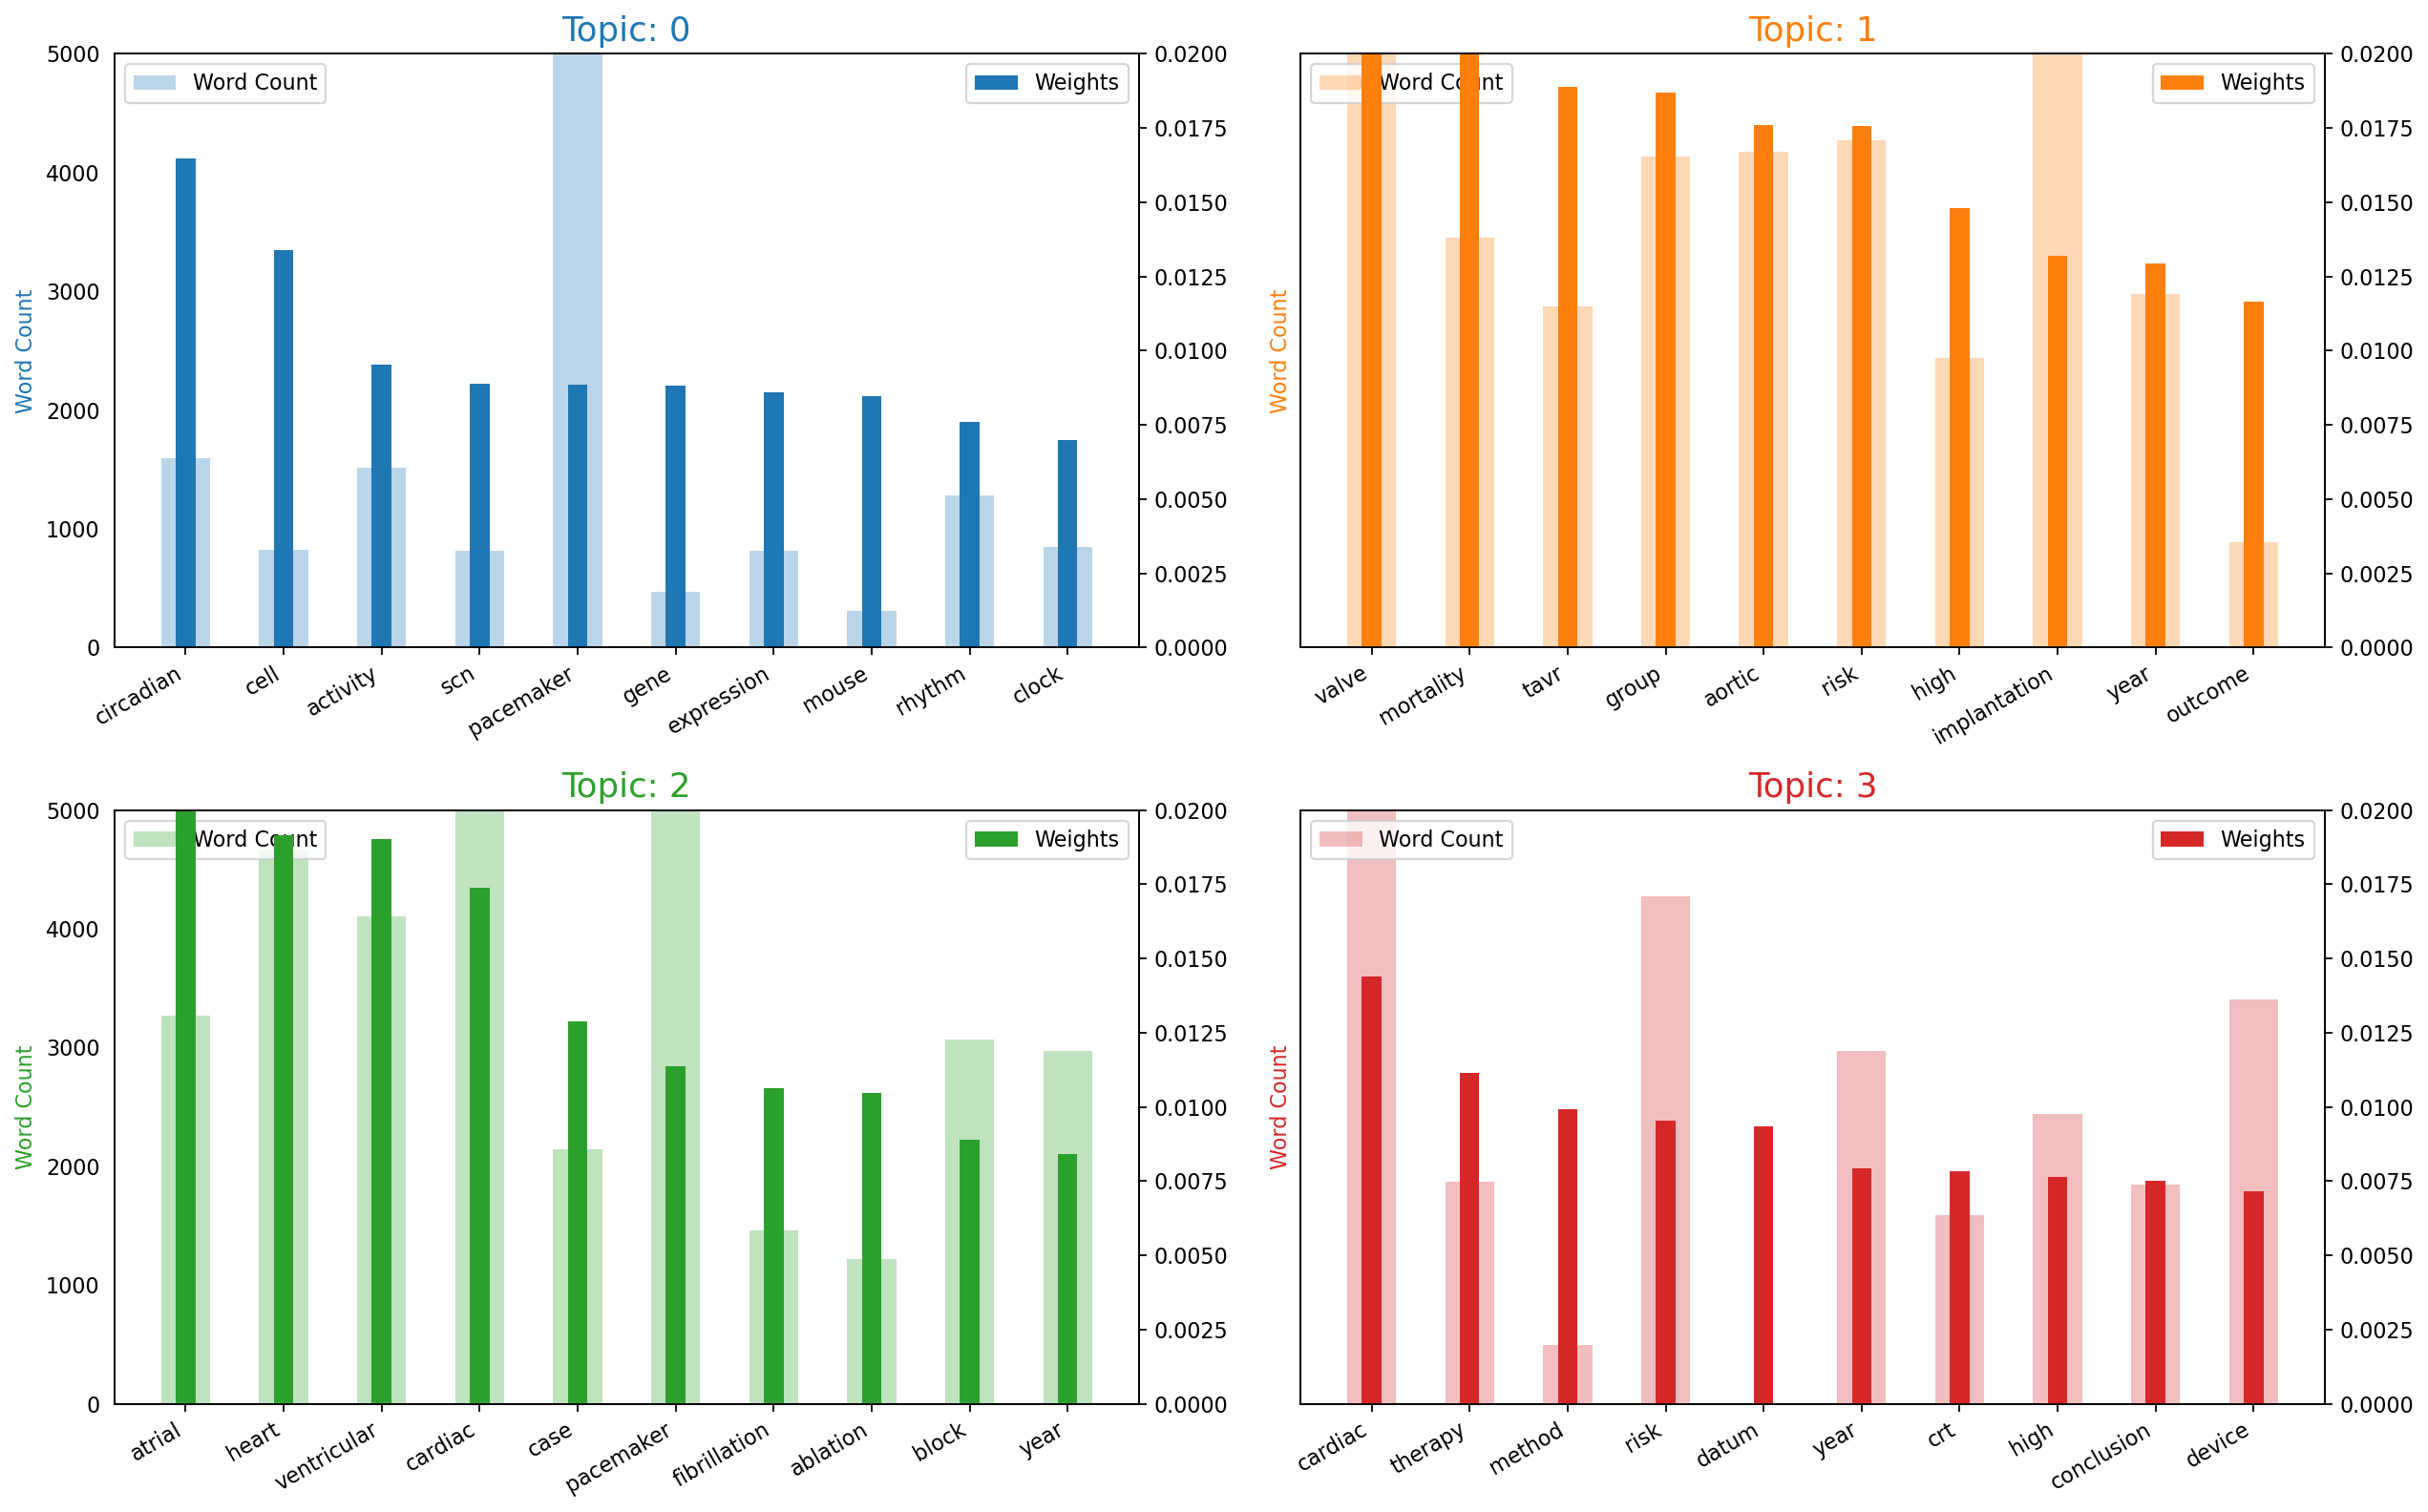

In [138]:
topic_word_freqBarPlot(lda_model,int(num_of_topics/2),2)